In [2]:
torch.cuda.is_available()

True

In [34]:
# imports
from scipy.stats import multiscale_graphcorr as MGC
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings

import sys
from pathlib import Path
from torchvision.transforms.functional import resize, InterpolationMode

sys.path.append('//home/azureuser/MGC_classifier/source')
import shape_functions


https://stackoverflow.com/questions/43729052/generator-function-yield-much-faster-then-iterator-class-next
Explains what type of function/generator to use for performance

In [79]:
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/better-1-gpu/code'

a
0 0

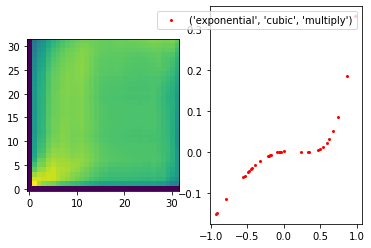

1 1

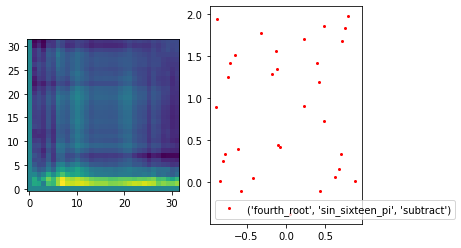

2 2

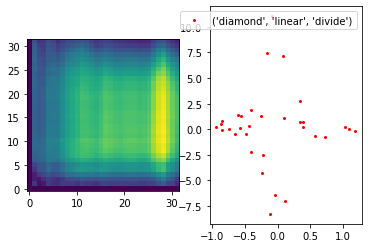

3 3

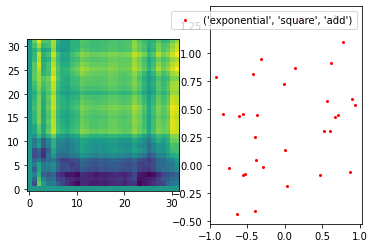

4 4

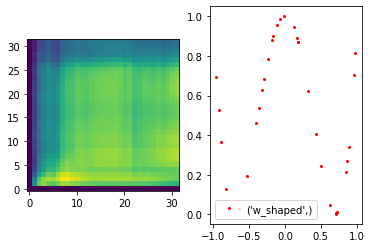

5 5

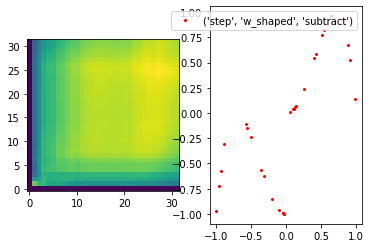

6 6

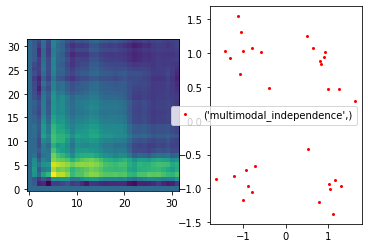

8 7

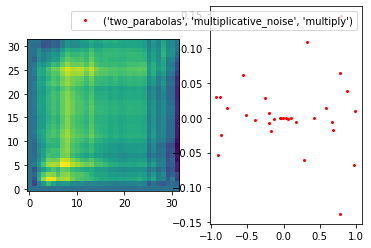

9 8

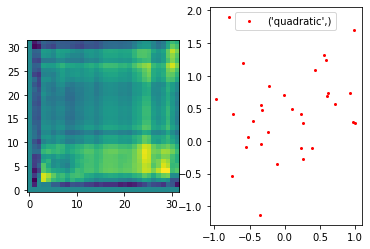

10 9

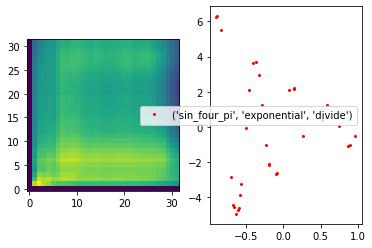

11 10

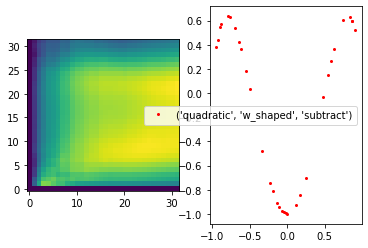

12 11

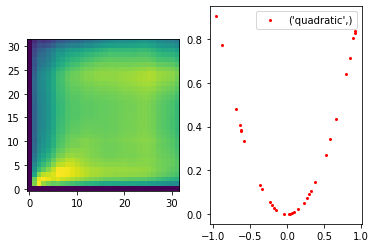

13 12

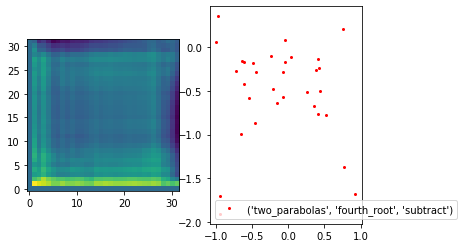

14 13

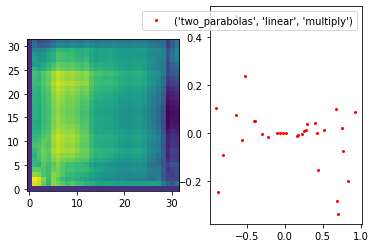

15 14

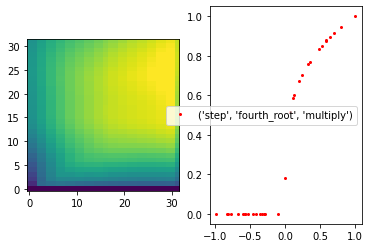

16 15

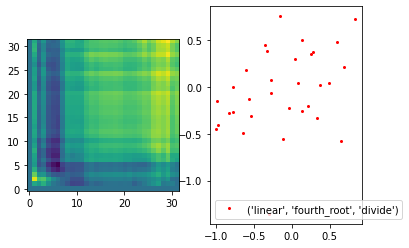

17 16

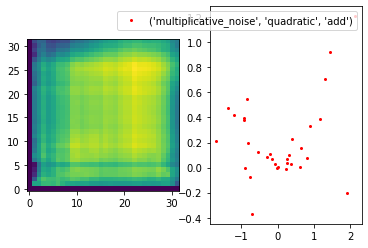

18 17

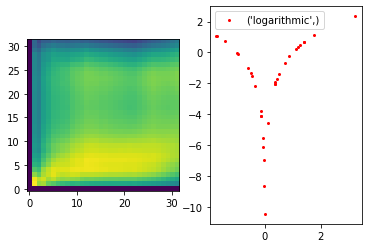

19 18

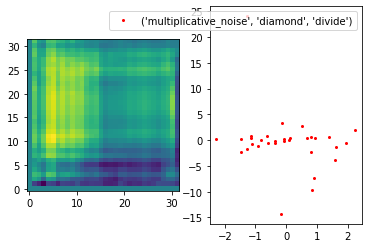

20 19

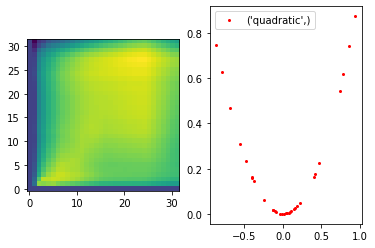

21 20

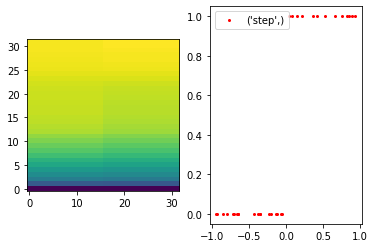

22 21

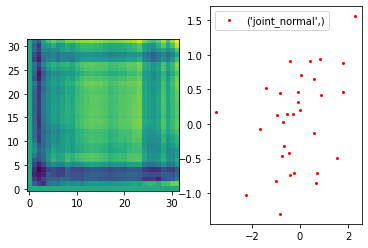

23 22

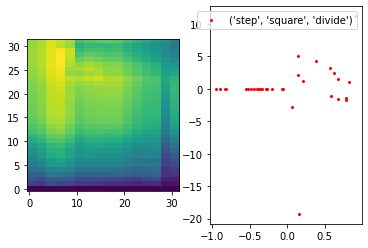

24 23

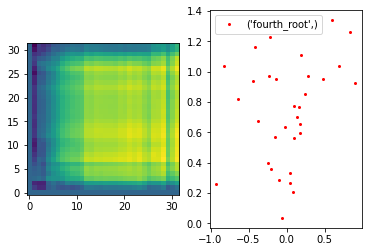

25 24

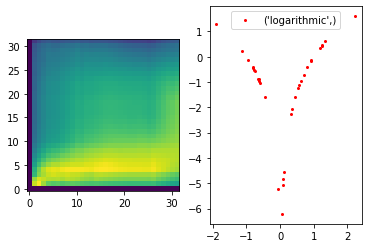

26 25

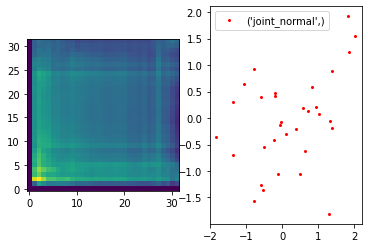

27 26

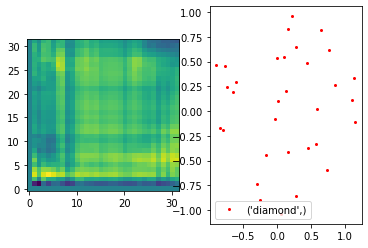

28 27

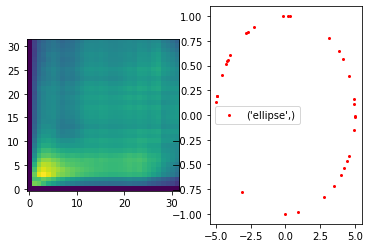

29 28

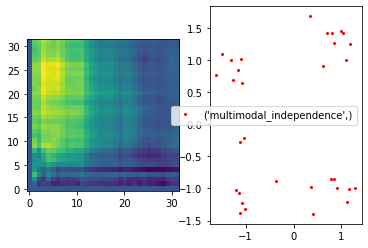

30 29

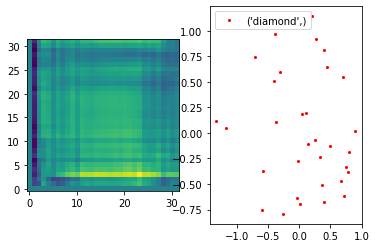

31 30

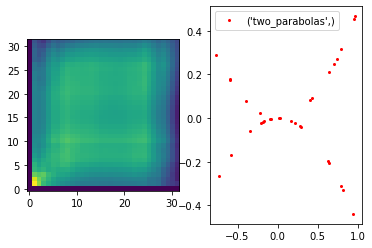

32 31

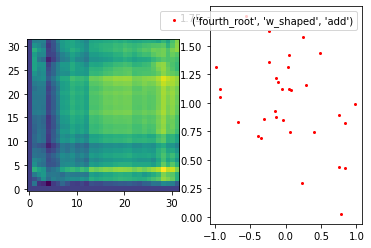

33 32

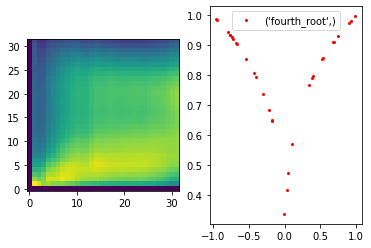

34 33

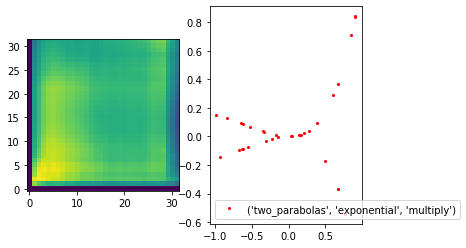

35 34

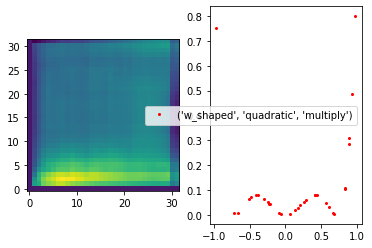

36 35

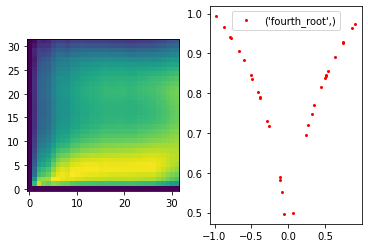

37 36

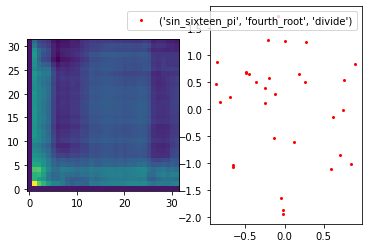

38 37

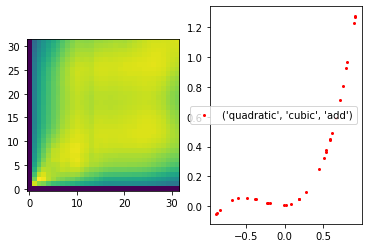

39 38

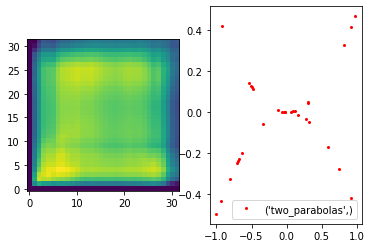

40 39

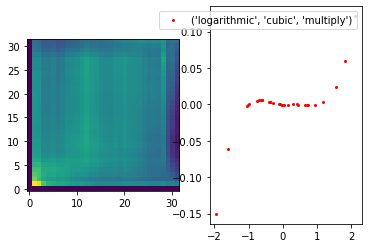

41 40

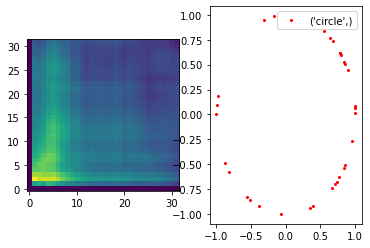

42 41

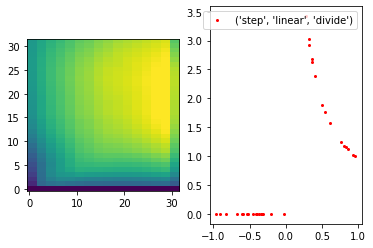

43 42

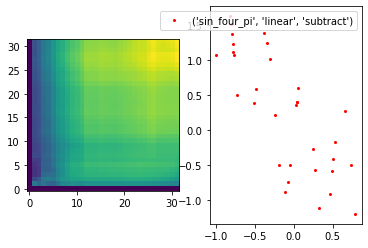

44 43

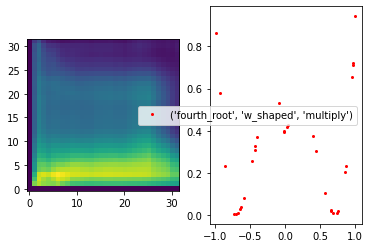

45 44

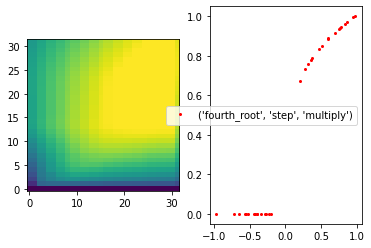

46 45

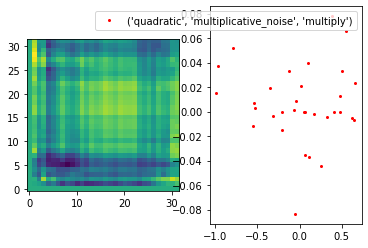

47 46

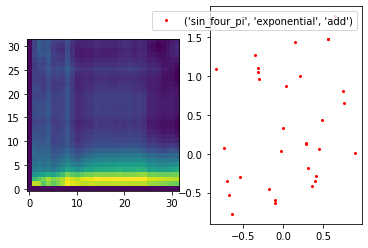

48 47

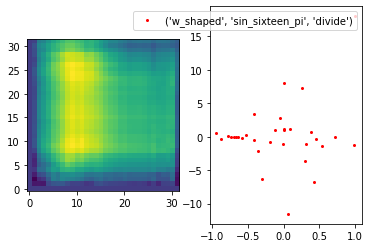

49 48

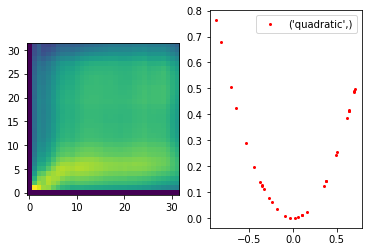

50 49

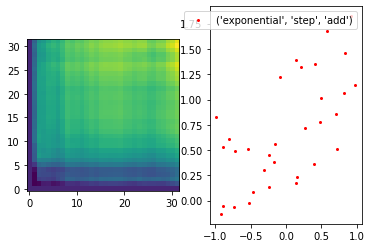

51 50

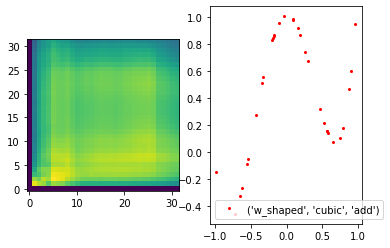

52 51

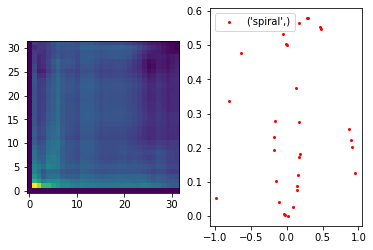

53 52

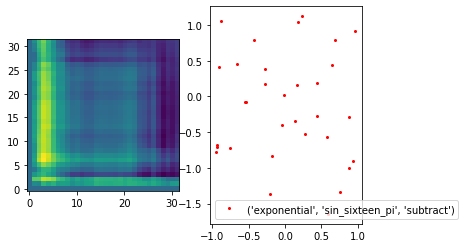

54 53

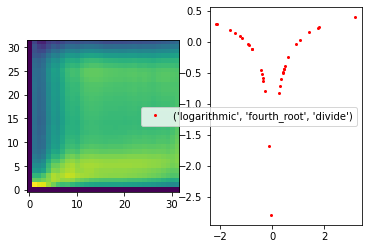

55 54

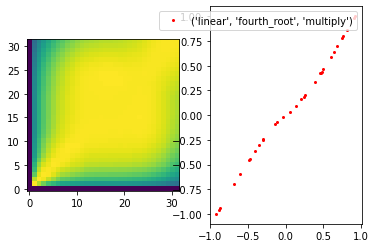

56 55

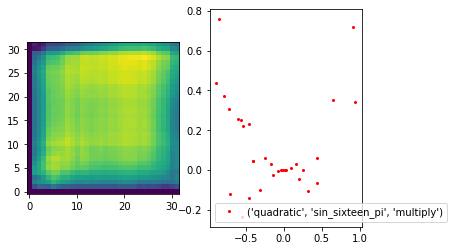

57 56

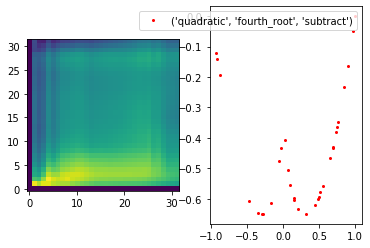

58 57

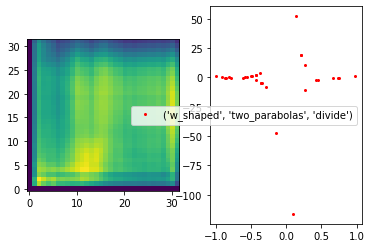

59 58

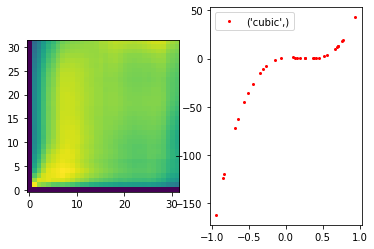

60 59

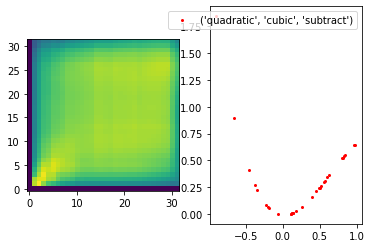

61 60

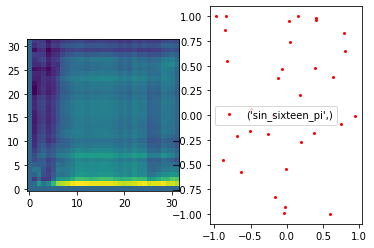

62 61

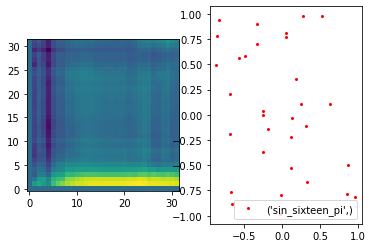

63 62

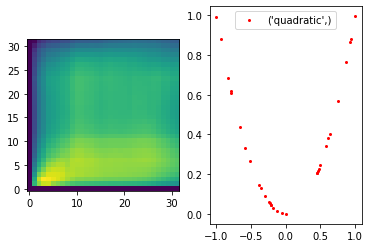

64 63

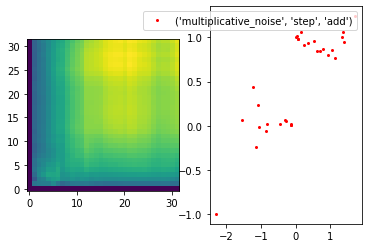

65 64

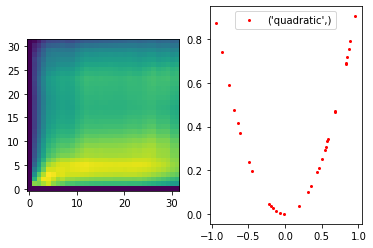

66 65

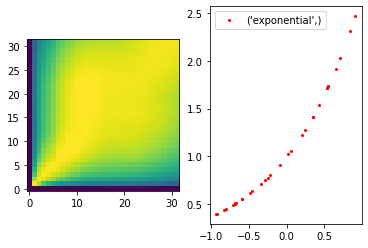

67 66

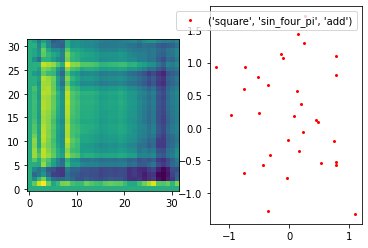

68 67

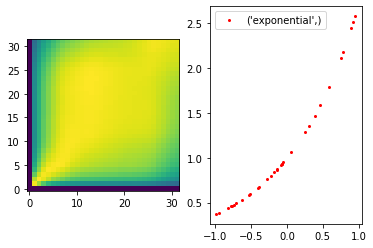

69 68

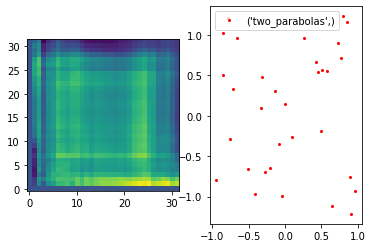

70 69

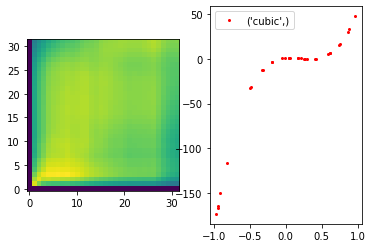

71 70

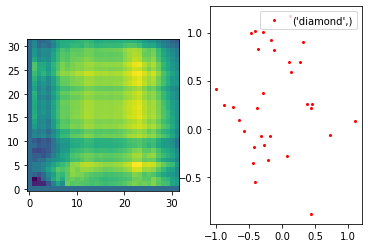

72 71

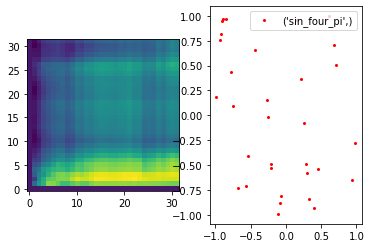

74 72

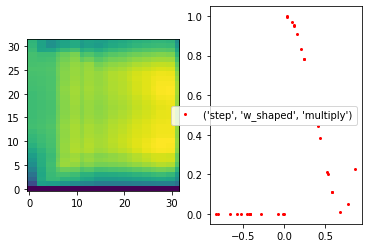

75 73

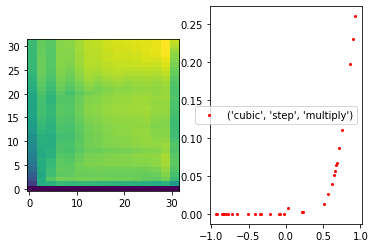

76 74

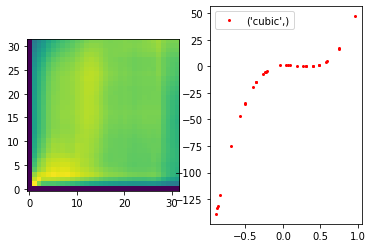

77 75

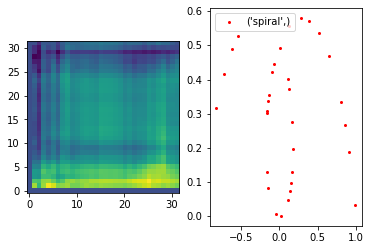

78 76

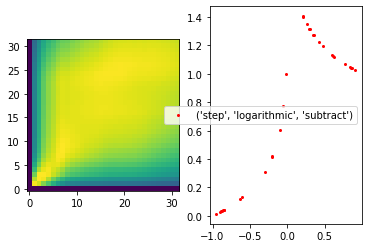

79 77

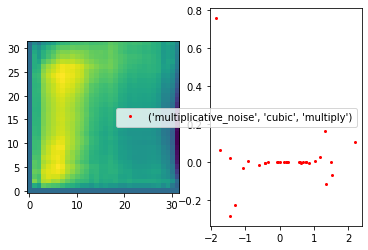

80 78

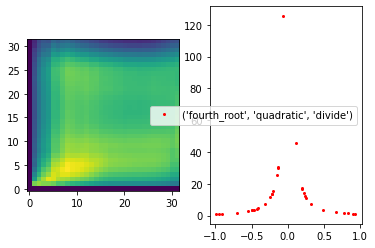

81 79

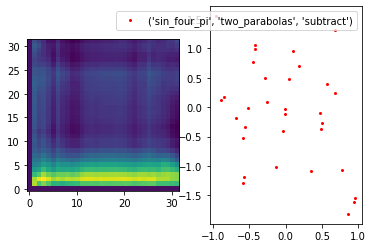

82 80

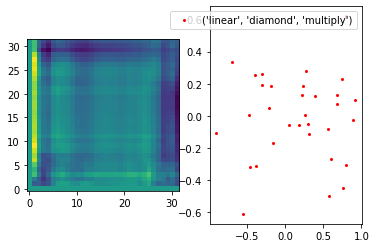

83 81

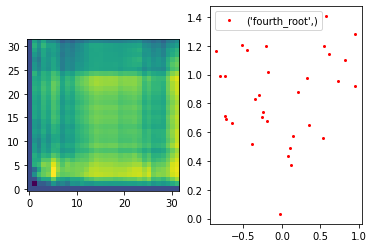

84 82

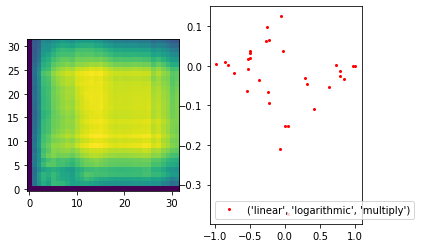

85 83

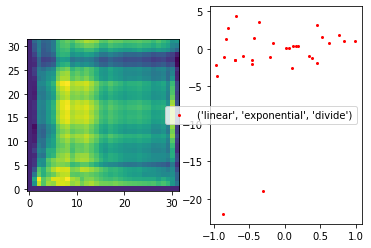

86 84

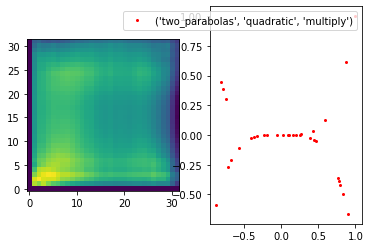

87 85

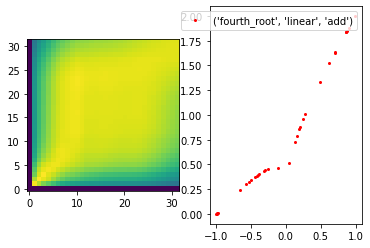

88 86

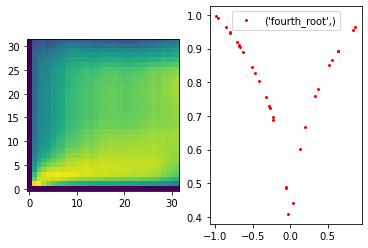

89 87

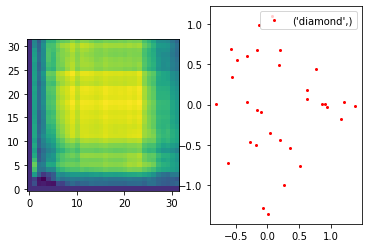

90 88

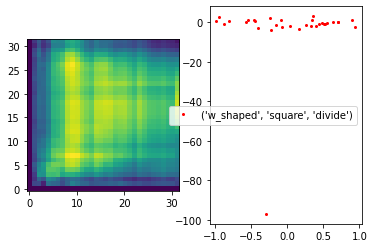

91 89

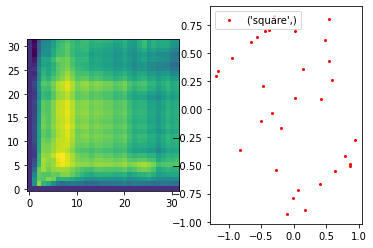

92 90

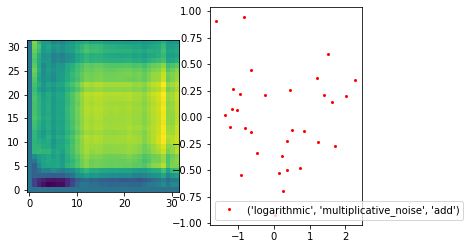

93 91

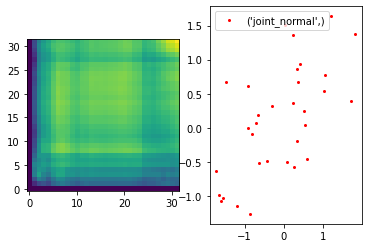

94 92

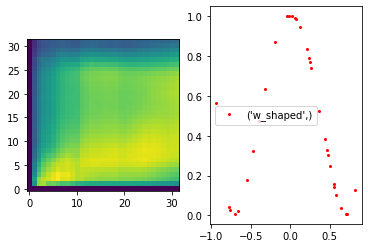

95 93

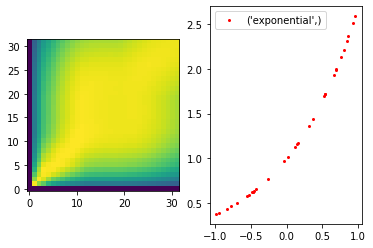

96 94

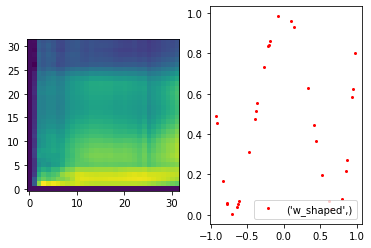

97 95

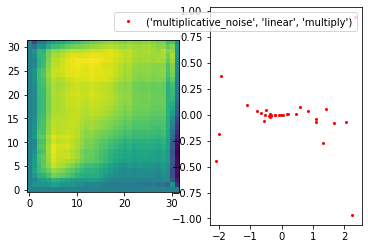

98 96

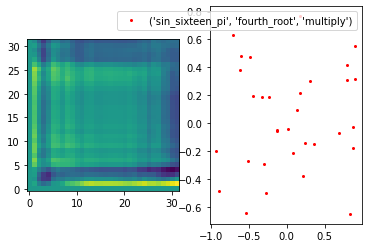

99 97

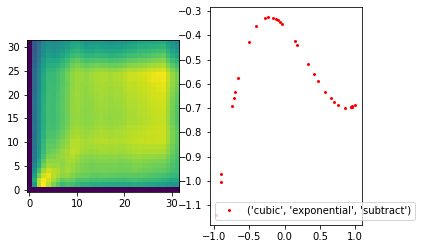

100 98

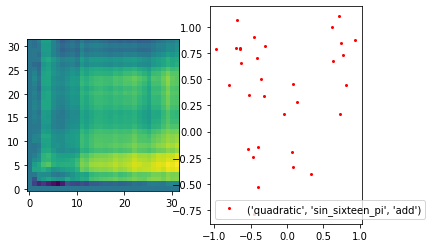

101 99

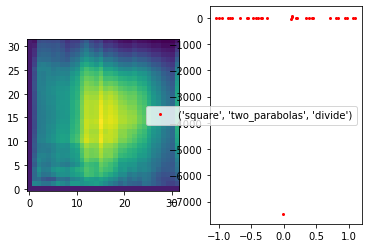

102 100

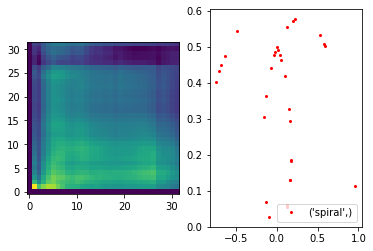

103 101

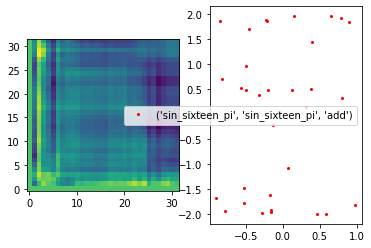

104 102

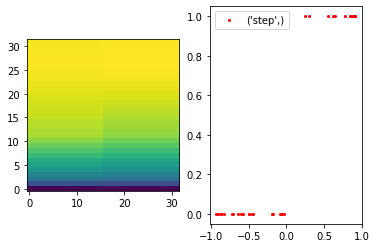

105 103

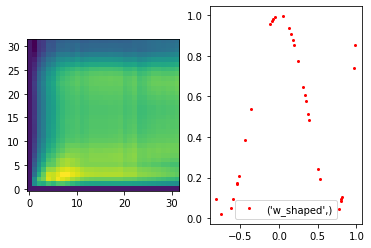

106 104

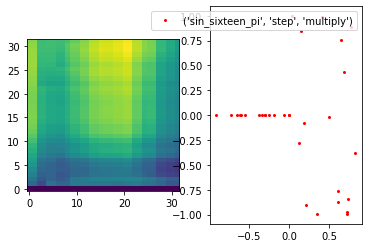

107 105

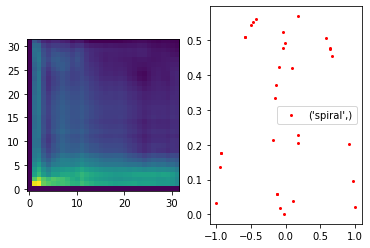

108 106

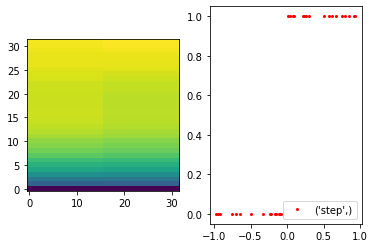

109 107

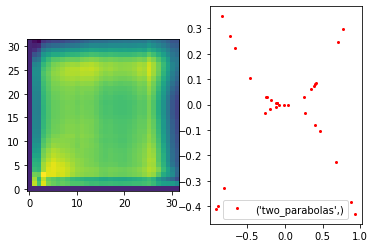

110 108

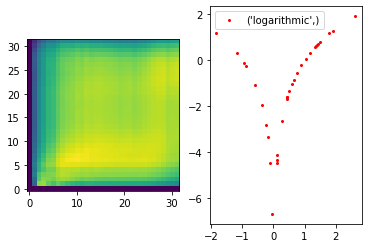

111 109

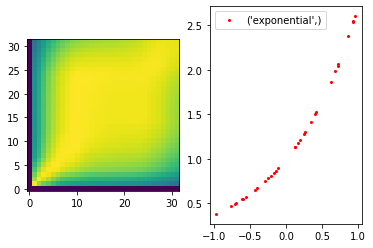

112 110

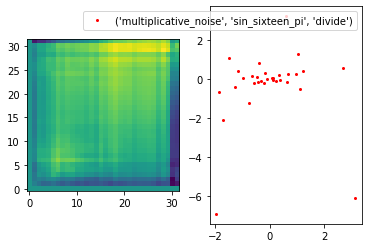

113 111

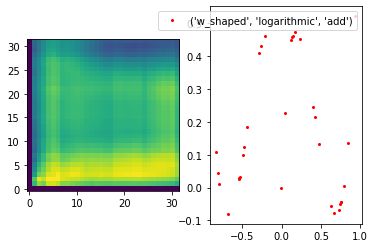

114 112

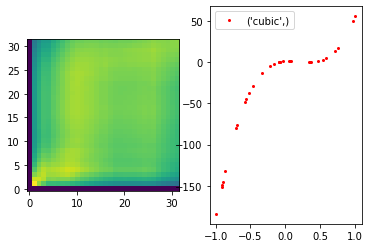

115 113

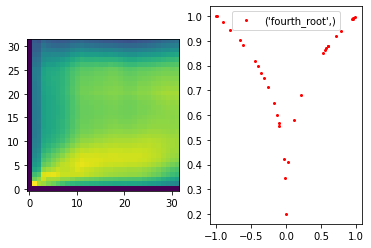

116 114

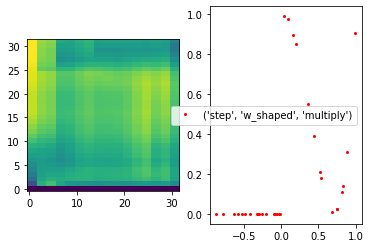

118 115

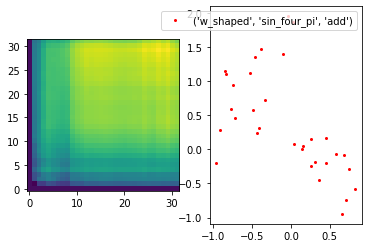

119 116

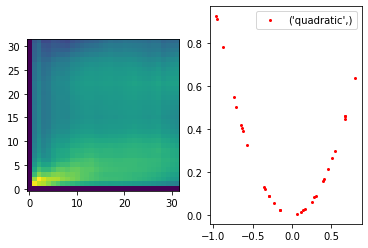

120 117

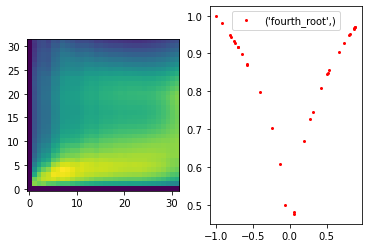

121 118

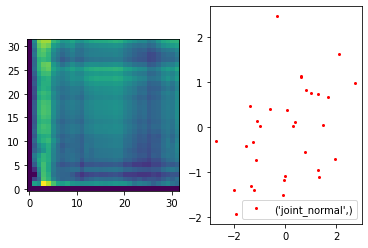

122 119

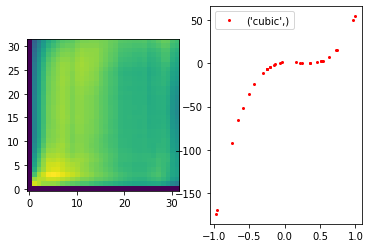

123 120

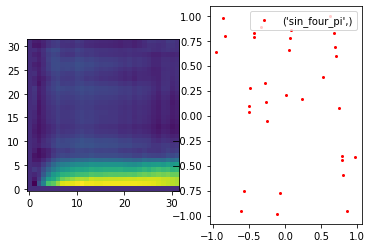

124 121

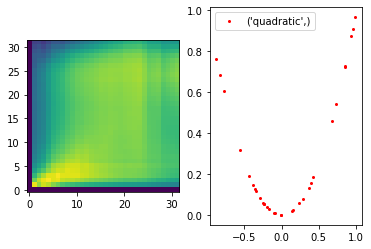

125 122

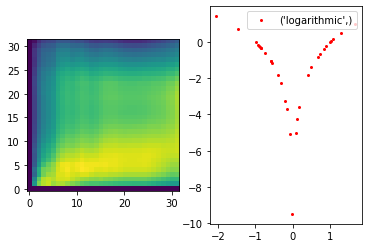

126 123

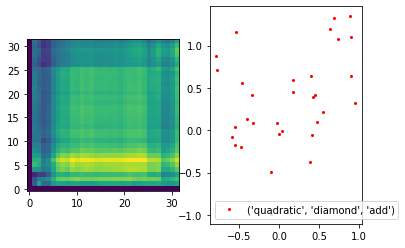

127 124

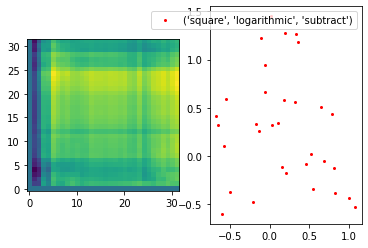

128 125

Process ForkPoolWorker-11948:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/anaconda/envs/azureml_py36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [51]:
class function_generator:
    def __init__(self, sample_size=32, output_size=32):
        
        # the size of the samples that go through MGC
        self.SIZE = sample_size
        # the size of the samples that actually come out
        # of the generator through interpolating
        self.output_size = output_size

        self.operations = [
            "multiply",
            "divide",
            "add",
            "subtract",
        ]

        self.hyppo_functions = [
            "linear",
            "exponential",
            "cubic",
            "joint_normal",
            "step",
            "quadratic",
            "w_shaped",
            "spiral",
            "logarithmic",
            "fourth_root",
            "sin_four_pi",
            "sin_sixteen_pi",
            "square",
            "two_parabolas",
            "circle",
            "ellipse",
            "diamond",
            "multiplicative_noise",
            "multimodal_independence",
        ]

        # two term operations
        self.two_term_operations = ["multiply", "divide"]

        # TODO adding and subtracting new terms
        self.add_term_operations = ["add", "subtract"]

        # check if all operations are contained in the other sets
        assert set(self.two_term_operations).union(
            set(self.add_term_operations)
        ) == set(self.operations)

        self.sample_size = sample_size

        self.operation_scale_dict = {
            "arccos": (-0.99, 0.99),
            "arccosh": (1.01, 10),
            "arcsin": (-0.99, 0.99),
            "arcsinh": (-np.pi, np.pi),
            "arctan": (-3, 3),
            "arctan2": ((-0.99, 0.99), (-0.99, 0.99)),
            "arctanh": (-0.99, 0.99),
            "heaviside": ((-0.99, 0.99), (-0.99, 0.99)),
            "log": (0.01, 3),
            "log10": (0.01, 3),
            "log1p": (0.01, 3),
            "log2": (0.01, 3),
            "multiply": ((-1, 1), (-1, 1)),
            "sin": (-np.pi, np.pi),
            "sinh": (-3, 3),
            "sqrt": (0, 1),
            "square": (-1, 1),
            "tan": (-np.pi / 2 + 0.01, np.pi / 2 - 0.01),
            "tanh": (-np.pi, np.pi),
            "divide": ((-2, 2), (0.01, 2)),
            "subtract": (-1, 1),
            "add": (-1, 1),
        }

        self.samples_dict = {}

    def yield_sample(self, a, b, p):
        """calls the other methods to yield samples lazily"""
        while True:

            # this controls how many successive operations are going
            n_functions = np.random.choice([1, 2])

            # get a random set of functions but make sure they are mixable
            functions = None
            while functions is None or \
                (set(functions).intersection([
                    "joint_normal", 
                    "spiral",
                    "uncorrelated_bernoulli",
                    "circle",
                    "ellipse",
                    "multimodal_independence",
                ]) and len(functions)>1):
                functions = np.random.choice(self.hyppo_functions, size = n_functions)

            # start a dictionary to store values
            funct_dict = {}

            # get the values for these functions
            for i, function in enumerate(functions):
                # get function and noise
                funct = getattr(shape_functions, function)
                noise = bool(np.random.choice([True, False], p=[0.1, 0.9]))
                # handle passing x to ensure that xs are the same
                if i==0:
                    x = None
                if function in ["multiplicative_noise", "multimodal_independence"]:
                    x, y = funct(self.sample_size, 1)

                elif function in ["linear","exponential","cubic", "step","quadratic", 
                                "w_shaped", "fourth_root", "sin_four_pi", 
                                "sin_sixteen_pi","square", 
                                "diamond"]:
                    x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), x=x)

                elif function in ["spiral", "circle", "ellipse"]:
                    x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b))

                elif function =="two_parabolas":
                    x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                                prob=p, x=x)
  
                elif function == 'uncorrelated_bernoulli':
                    x, y = funct(self.SIZE,1, noise=noise, prob=p)

                elif function in ["joint_normal"]:
                    x, y = funct(self.SIZE,1, noise=noise)
                
                elif function in ["logarithmic"]:
                    x, y = funct(self.SIZE,1, noise=noise, x=x)

                elif function == 'multimodal_independence':
                    x, y = funct(self.SIZE,1, prob=p, sep1=a, sep2=b)
                
                funct_dict[function] = {
                    'x':x,
                    'y':y
                }

            # store the operations for targets
            n_operations = n_functions-1
            order_of_operations = np.random.choice(self.operations, size = n_operations)

            # initialize a list for the terms
            terms = []
            x, y = None, None
            for i, function in enumerate(functions):

                if (x is None) or (y is None):
                    x = funct_dict[function]['x']
                    y = funct_dict[function]['y']
                    
                else:
                    # get the actual function with this operator
                    y = y/np.nanmax(np.abs(y))
                    operator = order_of_operations[i-1]
                    funct = getattr(np, operator)
                    
                    # get the new values
                    y_new = funct_dict[function]['y']/np.nanmax(np.abs(funct_dict[function]['y']))

                    # new value for y
                    y = funct(y,y_new)

            #filter out inf and nan
            inf_mask = ~(np.abs(y) == np.inf)
            nan_mask = ~np.isnan(y)
            x, y = x[nan_mask & inf_mask], y[nan_mask & inf_mask]

            yield (x, y), (*functions, *order_of_operations)

    def generate_MGC_maps(self, n_samples, generator_parameters):

        a, b, p = generator_parameters
        # temporary
        a,b,p = -1,1,0.5
        # instantiate the generator
        gen = self.yield_sample(a,b,p)

        labels = []
        # generate the data
        for i in range(n_samples):
            print(f"\r{i} {len(self.samples_dict)}", end="")
            (x, y), label = next(gen)

            labels.append(label)

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    _, _, mgc_dict = MGC(x, y, reps=0, workers=-1)

                # find shortest dimension
                min_dim_mask = mgc_dict["mgc_map"].shape == min(mgc_dict["mgc_map"].shape)
                
                # set that one to be nearested
                size_nearest = np.array(mgc_dict["mgc_map"].shape)
                size_nearest[min_dim_mask] = self.output_size
                size_nearest = list(size_nearest)
                
                # interpolate nearest that dimension
                mgc_map = resize(torch.tensor(mgc_dict["mgc_map"]).unsqueeze(0), interpolation=InterpolationMode.NEAREST, size=size_nearest)

                # resize bilinear the other dimension
                size_max = (self.output_size, self.output_size)
                mgc_map = resize(mgc_map, size = size_max)

                self.plot_map(x,y,mgc_map, label)

                self.samples_dict[i] = (mgc_map, (x, y), label)
            except IndexError:
                print(f"\r{i} {len(self.samples_dict)}, {x.shape}, {y.shape}", end="")
                # mgc has a bug when it defaults to global scale

    def plot_map(self, x,y, mgc_map, label):
        fig, axs = plt.subplots(1,2)
        axs[0].imshow(mgc_map[0,:,:])
        axs[0].invert_yaxis()
        axs[1].plot(x, y, 'ro', markersize=2, label = label)
        axs[1].legend()
        plt.tight_layout
        plt.pause(0.001)


print("a")
class_instance = function_generator(32)
a_test,b_test,p_test = -1,1,0.5
generator = class_instance.yield_sample(a_test,b_test,p_test)
class_instance.generate_MGC_maps(1000, (a_test,b_test,p_test))

# should be around 12 gb of data ofr 100,000 samples


In [74]:
bool(set([1,2,3]).intersection(set([4,5,6, 1])))

True

In [75]:
torch.cuda.is_available()

True

## save the configurations for the hyppo.tools operators if I want to refine this later

`if operator in ['multiplicative','multimodal_independence']:
        noise = False
      else:
        noise = False

      if operator in ["linear","exponential","cubic", "step","quadratic", 
                      "w_shaped", "spiral", "fourth_root", "sin_four_pi", 
                      "sin_sixteen_pi","square", "circle", 
                      "ellipse", "diamond"]:
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b))
      
      elif operator =="two_parabolas":
        x, y = funct(self.SIZE,1, noise=noise, low=min(a,b), high=max(a,b), 
                     prob=np.random.random())
        
      elif operator == 'uncorrelated_bernoulli':
        x, y = funct(self.SIZE,1, noise=noise, prob=np.random.random())

      elif operator in ["joint_normal", "logarithmic"]:
        x, y = funct(self.SIZE,1, noise=noise)
      
      elif operator == 'multimodal_independence':
        x, y = funct(self.SIZE,1, prob=np.random.random(), sep1=a, sep2=b)

      elif operator == 'multiplicative':
        x, y = funct(self.SIZE,1)`